In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, confusion_matrix

from sklearn.calibration import CalibratedClassifierCV


from sklearn.metrics import f1_score,precision_recall_curve,roc_curve, recall_score,precision_score

from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

In [2]:
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


In [3]:
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)

In [4]:
import os
os.listdir('../input/wns-analyticswizard')

['test_aq1fgdb', 'train_na17sgz', 'sample_submission_ipsblct']

In [5]:
%%time
Path ='../input/wns-analyticswizard/'


train_df = pd.read_csv(Path+'train_na17sgz/train.csv')
test_df = pd.read_csv(Path+'test_aq1fgdb/test.csv')
viewlog_df = pd.read_csv(Path+'train_na17sgz/view_log.csv')
itemdata_df = pd.read_csv(Path+'train_na17sgz/item_data.csv')
subm_df = pd.read_csv(Path+'sample_submission_ipsblct/sample_submission.csv')

targetcol = 'is_click'
target = train_df[targetcol]

CPU times: user 2.14 s, sys: 460 ms, total: 2.6 s
Wall time: 2.61 s


In [6]:
# subm_df.head()

In [7]:
print(train_df.shape, test_df.shape)
print(test_df.shape[0] / train_df.shape[0])

(237609, 7) (90675, 6)
0.3816143327904246


In [8]:
print(train_df['os_version'].unique())
print(train_df['impression_id'].nunique())
print(train_df['user_id'].nunique())
print(train_df['app_code'].nunique())
train_df.head()

['old' 'latest' 'intermediate']
237609
74723
490


,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [9]:
train_df['impression_time'].min()
train_df['impression_time'].max()

'2018-12-13 07:43:00'

In [10]:
print(viewlog_df.groupby('user_id')['session_id'].count())
print(viewlog_df['server_time'].max())
viewlog_df.head()


user_id
0         42
1          8
2        165
3          8
4          2
        ... 
92582     11
92583      3
92584      3
92585      5
92586     22
Name: session_id, Length: 89157, dtype: int64
2018-12-11 23:59:00


,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [11]:
test_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,latest,1
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,latest,1


In [12]:
#check if there are any missing data.

def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [13]:
%%time
missing_data(train_df)

CPU times: user 104 ms, sys: 0 ns, total: 104 ms
Wall time: 102 ms


,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
Total,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0
Types,object,object,int64,int64,object,int64,int64


In [14]:
%%time
missing_data(test_df)

CPU times: user 36 ms, sys: 4 ms, total: 40 ms
Wall time: 39.5 ms


,impression_id,impression_time,user_id,app_code,os_version,is_4G
Total,0,0,0,0,0,0
Percent,0,0,0,0,0,0
Types,object,object,int64,int64,object,int64


In [15]:
%%time
train_df.describe()

CPU times: user 48 ms, sys: 4 ms, total: 52 ms
Wall time: 51.2 ms


,user_id,app_code,is_4G,is_click
count,237609.000000,237609.000000,237609.000000,237609.000000
mean,46454.526828,249.099971,0.361312,0.045714
std,26802.726666,135.213609,0.480382,0.208864
min,0.000000,0.000000,0.000000,0.000000
25%,23197.000000,163.000000,0.000000,0.000000
50%,46597.000000,213.000000,0.000000,0.000000
75%,69684.000000,385.000000,1.000000,0.000000
max,92586.000000,522.000000,1.000000,1.000000


In [16]:
%%time
test_df.describe()

CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 23.6 ms


,user_id,app_code,is_4G
count,90675.00000,90675.000000,90675.000000
mean,46417.71013,254.793703,0.357872
std,26835.33356,133.411434,0.479377
min,1.00000,0.000000,0.000000
25%,23029.00000,190.000000,0.000000
50%,46557.00000,213.000000,0.000000
75%,69764.50000,386.000000,1.000000
max,92586.00000,522.000000,1.000000


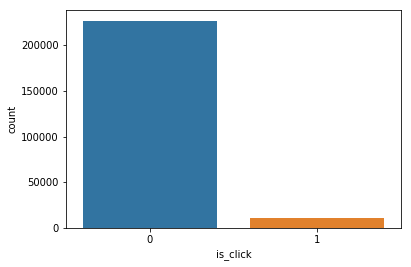

In [17]:
sns.countplot(train_df[targetcol])

In [18]:
print("There are {}% target values with 1".format(100 * train_df[targetcol].value_counts()[1]/train_df.shape[0]))

There are 4.571375663379754% target values with 1


Density Plots

In [19]:
def plot_feature_distribution(df1, df2, label1, label2, features,rows=6,cols=4):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,4,figsize=(18,22))

    for feature in features:
        print('cur feature:',feature)
        i += 1
        plt.subplot(rows,cols,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

Duplicate Values

In [20]:
len(list(train_df.columns))

7

In [21]:
%%time
features = train_df.columns.values[1:40]
exclude_cols =['loan_id','financial_institution','origination_date',
               'first_payment_date','loan_purpose','source',targetcol]
features = [col for col in train_df.columns if col not in exclude_cols]

# unique_max_train = []
# unique_max_test = []
# for feature in features:
#     values = train_df[feature].value_counts()
#     unique_max_train.append([feature, values.max(), values.idxmax()])
#     values = test_df[feature].value_counts()
#     unique_max_test.append([feature, values.max(), values.idxmax()])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 134 µs


In [22]:
# np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
#             sort_values(by = 'Max duplicates', ascending=False).head(40))

In [23]:
# np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
#             sort_values(by = 'Max duplicates', ascending=False).head(15))

Model

In [24]:
# exclude_cols =['Date.of.Birth','Employment.Type','DisbursalDate',
#                'PERFORM_CNS.SCORE.DESCRIPTION','AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH',
#                'UniqueID',targetcol]
# features = [c for c in train_df.columns if c not in exclude_cols]
# print(features)

In [25]:
#generate new features
train_df['istrain']=1
test_df['istrain']=0
catcols =['os_version']
combined= pd.concat([train_df,test_df],axis=0)
# combined = pd.get_dummies(combined[features + catcols + ['istrain']])
combined = pd.get_dummies(combined[ catcols + ['istrain']])

train_dummies = combined[combined['istrain']==1]
test_dummies = combined[combined['istrain']==0]

del combined, train_dummies['istrain'],test_dummies['istrain'], train_df['istrain'], test_df['istrain']

train_df= pd.concat([train_df,train_dummies],axis=1)
test_df= pd.concat([test_df,test_dummies],axis=1)


print(train_df.head())
print(test_df.head())

#categorical to dummies

                      impression_id      impression_time  user_id  app_code  \
0  c4ca4238a0b923820dcc509a6f75849b  2018-11-15 00:00:00    87862       422   
1  45c48cce2e2d7fbdea1afc51c7c6ad26  2018-11-15 00:01:00    63410       467   
2  70efdf2ec9b086079795c442636b55fb  2018-11-15 00:02:00    71748       259   
3  8e296a067a37563370ded05f5a3bf3ec  2018-11-15 00:02:00    69209       244   
4  182be0c5cdcd5072bb1864cdee4d3d6e  2018-11-15 00:02:00    62873       473   

     os_version  is_4G  is_click  os_version_intermediate  os_version_latest  \
0           old      0         0                        0                  0   
1        latest      1         1                        0                  1   
2  intermediate      1         0                        1                  0   
3        latest      1         0                        0                  1   
4        latest      0         0                        0                  1   

   os_version_old  
0               1  
1   

In [26]:
#generate date features
def gen_date_feats(data,orig_date_format):
    data['impression_time']= pd.to_datetime(data['impression_time'],format=orig_date_format)
    data['impression_year']=data['impression_time'].dt.year
    data['impression_month']=data['impression_time'].dt.month
    data['impression_day']=data['impression_time'].dt.day
    data['impression_hour']=data['impression_time'].dt.hour
    
    return data

timeformat = '%Y-%m-%d %H:%M:%S'
train_df = gen_date_feats(train_df,timeformat)
test_df = gen_date_feats(test_df,timeformat)

cols = ['impression_time','impression_year','impression_month','impression_day',
        'impression_hour']
print(train_df[cols].head())
print(test_df[cols].head())

      impression_time  impression_year  impression_month  impression_day  \
0 2018-11-15 00:00:00             2018                11              15   
1 2018-11-15 00:01:00             2018                11              15   
2 2018-11-15 00:02:00             2018                11              15   
3 2018-11-15 00:02:00             2018                11              15   
4 2018-11-15 00:02:00             2018                11              15   

   impression_hour  
0                0  
1                0  
2                0  
3                0  
4                0  
      impression_time  impression_year  impression_month  impression_day  \
0 2018-12-13 07:44:00             2018                12              13   
1 2018-12-13 07:45:00             2018                12              13   
2 2018-12-13 07:46:00             2018                12              13   
3 2018-12-13 07:47:00             2018                12              13   
4 2018-12-13 07:48:00             201

In [27]:
#convert cols to 'categorical' for model
for df in [train_df,test_df]:
    df['app_code'] = df['app_code'].astype('category')

In [28]:
t0 = train_df.loc[train_df[targetcol] == 0]
t1 = train_df.loc[train_df[targetcol] == 1]
exclude_cols =['impression_id','os_version','impression_time',targetcol]
features = [col for col in train_df.columns if col not in exclude_cols]

print(len(features))
print(features)

10
['user_id', 'app_code', 'is_4G', 'os_version_intermediate', 'os_version_latest', 'os_version_old', 'impression_year', 'impression_month', 'impression_day', 'impression_hour']


cur feature: user_id
cur feature: app_code
cur feature: is_4G
cur feature: os_version_intermediate
cur feature: os_version_latest
cur feature: os_version_old
cur feature: impression_year
cur feature: impression_month
cur feature: impression_day
cur feature: impression_hour


<Figure size 432x288 with 0 Axes>

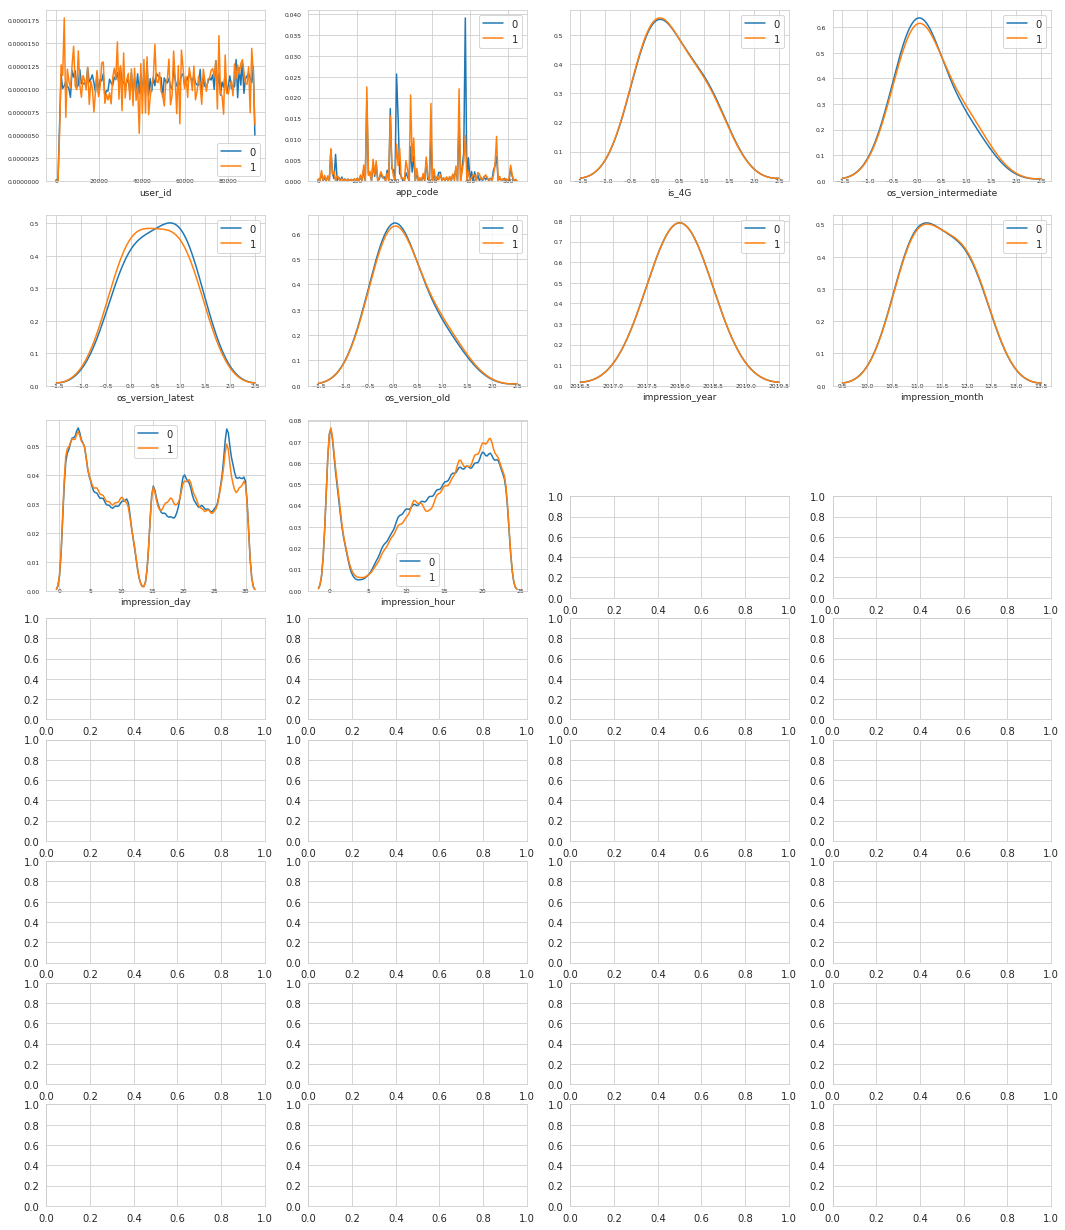

In [29]:
# features = train_df.columns.values[1:40]
plot_feature_distribution(t0, t1, '0', '1', features)

In [30]:
# param = {
#     'bagging_freq': 5,
#     'bagging_fraction': 0.4,
#     'boost_from_average':'false',
#     'boost': 'gbdt',
#     'feature_fraction': 0.05,
#     'learning_rate': 0.01,
#     'max_depth': -1,  
#     'metric':'auc',
#     'min_data_in_leaf': 80,
#     'min_sum_hessian_in_leaf': 10.0,
#     'num_leaves': 13,
#     'num_threads': 8,
#     'tree_learner': 'serial',
#     'objective': 'binary', 
#     'verbosity': 1
# }

In [31]:
param = {
         'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
#          'objective':'None',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'AUC',
         "scale_pos_weight": 2,
#          "is_unbalance": True,
         "lambda_l1": 0.1,
#          "lambda_l1": 0.7,
#          "lambda_l2": 0.7,
         "verbosity": -1,
         "nthread": 4,
         'n_estimators' : 10000,
         "random_state": 4590}


early_stopping_rounds = 300

In [32]:
#  param=  {
#     'colsample_bytree':0.759164331,
#     'min_child_samples':85,
#     'num_leaves':20,
#     'reg_alpha':0.155214401,
#     'reg_lambda':0.594730243,
#     'subsample':0.867816493,
#     'subsample_for_bin':150000,
#     'learning_rate': 0.01,
#     'boosting': 'gbdt',
#     'bagging_seed': 2019,
#     'bagging_freq': 2,
#     'min_data_in_bin': 100,
#     'n_estimators': 10000,
#     'objective': 'binary',
#     'metric': 'None',
#     'random_state': 2333,
#     'max_depth': 15,
#     'scale_pos_weight': 2
#     }

In [33]:
early_stopping_rounds = 300

In [34]:
def lgb_logle_obj(preds, train_data):
    labels = train_data.get_label()
    residual = (labels - preds).astype("float")
    
    preds = 1.0 / (1.0 + np.exp(-preds))
    grad_part = preds - labels
    
    grad = np.where(residual>0.7, 10.0*grad_part, grad_part)
    hess_part = preds * (1.0 - preds)
    hess = np.where(residual>0.7, 10.0*hess_part, hess_part)
    return grad, hess

def lgb_logle(preds, train_data):
    labels = train_data.get_label()
    # return a pair metric_name, result
    # since preds are margin(before logistic transformation, cutoff at 0)
    
    residual = (labels - preds).astype("float")
    
#     optcutoff,f1score = get_opt_cutoff_fbeta(labels,preds)
#     optcutoff =0.0
    loss_part = float(sum(labels != (preds > 0.0))) / len(labels)
#     loss_part = (labels != (preds > 0.0)).astype("float")

    loss = np.where(residual>0.7, 10.0*loss_part, loss_part) 

    return 'log likelihood error', np.mean(loss), False
def lgb_sk_logle(labels, preds):
    residual = (labels - preds).astype("float")
    loss_part = float(sum(labels != (preds > 0.0))) / len(labels)
    loss = np.where(residual>0.7, 10.0*loss_part, loss_part) 
  
    return 'log likelihood error', np.mean(loss), False

def get_f1loss_score(labels,preds):
    optcutoff,f1score = get_opt_cutoff_prec(labels,preds)
    f1loss = 1 - f1score
    return f1loss

def lgb_fbeta(preds, train_data):
    labels = train_data.get_label()

    optcutoff,fscore = get_opt_cutoff_fbeta(labels,preds,beta=100)
    return 'fbeta_score', fscore, True

def lgb_fbeta_auc(preds, train_data):
    labels = train_data.get_label()

    optcutoff,fscore = get_opt_cutoff_fbeta(labels,preds,beta=100)
    aucscore = roc_auc_score(labels,preds)
    return 'fbeta_auc_score', fscore+aucscore, True

def lgb_f1_auc(preds, train_data):
    labels = train_data.get_label()
    optcutoff,f1score = get_opt_cutoff_prec(labels,preds)
    aucscore = roc_auc_score(labels,preds)
    return 'f1auc_score', f1score+aucscore, True

def lgb_f1(preds, train_data):
    labels = train_data.get_label()
#     preds = preds.reshape(-1, 2)
#     print('preds before :',preds[0:10])
#     preds = preds.argmax(axis = 1)
#     preds = preds.min(axis = 1)
#     f1score = f1_score(preds, labels, average = 'micro')
    optcutoff,f1score = get_opt_cutoff_prec(labels,preds)
    
#     bscore = brier_score_loss(labels,preds) 
#     bss = 1- (bscore/0.010944928684627575) 
    return 'f1_score', f1score, True

def convert_probtolabels(preds,cutoff=0.5):
    y_bin= preds.copy()
    y_bin[preds>cutoff] = 1
    y_bin[preds<=cutoff] = 0
    y_bin=y_bin.astype(int)

    return y_bin

def get_opt_cutoff_fbeta(labels,preds,beta=5):
    precision, recall, thresholds  = precision_recall_curve(labels, preds)
    beta_square = beta**2
    f_score= (1+beta_square)*((precision*recall)/(beta_square*precision+recall))
    optimal_idx = np.nanargmax(f_score)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold, f_score[optimal_idx]

def get_opt_cutoff_prec(labels,preds):
    precision, recall, thresholds  = precision_recall_curve(labels, preds)
    f1_score= 2*((precision*recall)/(precision+recall))
    optimal_idx = np.nanargmax(f1_score)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold, f1_score[optimal_idx]
def computef1scoreandconfmatrix(y_true,y_preds):    
    opt_cutoff, f1score = get_opt_cutoff_prec(y_true,y_preds)
    print('opt_cutoff:',opt_cutoff)
    print('f1 score:',f1score)
    pred_labels = convert_probtolabels(y_preds,cutoff=opt_cutoff)
    print('conf matrix:',confusion_matrix(y_true,pred_labels))
    return opt_cutoff,f1score,pred_labels

In [35]:
# train_df_copy = train_df.copy()
# test_df_copy = test_df.copy()
# target_copy = target.copy()

In [36]:
# #temporary test split 
# random_fold = 0

# folds = StratifiedKFold(n_splits=5, shuffle=False, random_state=1000)
# for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    
#     if fold_!=random_fold:
#         continue
#     new_train = train_df.iloc[trn_idx]
#     new_test =  train_df.iloc[val_idx]
#     new_target = target.iloc[trn_idx]
#     test_target = target.iloc[val_idx]
#     break
    

# train_df = new_train.copy()
# test_df = new_test.copy()
# target=new_target.copy()

# print(train_df.shape,test_df.shape)

In [37]:
# train_df = train_df_copy.copy()
# test_df = test_df_copy.copy()
# target  = target_copy.copy()

In [38]:
def runlgb(train_df,test_df,target,n_splits=5, random_state=888):
    
    folds = StratifiedKFold(n_splits=n_splits, shuffle=False, random_state=random_state)
    oof = np.zeros(len(train_df))
    predictions = np.zeros(len(test_df))
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):

        train_cur = train_df.iloc[trn_idx][features]
        val_cur = train_df.iloc[val_idx][features]
        target_cur = target.iloc[trn_idx]
        target_val_cur = target.iloc[val_idx]

        print("Fold {}".format(fold_))
        trn_data = lgb.Dataset(train_cur, label=target_cur)
        val_data = lgb.Dataset(val_cur, label=target_val_cur)

        num_round = 1000000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], 
                        verbose_eval=100, 
#                         feval=lgb_logle,
                        early_stopping_rounds = early_stopping_rounds)
        oof[val_idx] = clf.predict(val_cur, num_iteration=clf.best_iteration)
        computef1scoreandconfmatrix(target_val_cur,oof[val_idx]) 
        print("AUC score: {:<8.5f}".format(roc_auc_score(target_val_cur,oof[val_idx])))

        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

    print()
    print("CV AUC score: {:<8.5f}".format(roc_auc_score(target, oof)))
    opt_cutoff, f1score, oof_labels = computef1scoreandconfmatrix(target,oof)
    predictions_labels = convert_probtolabels(predictions,cutoff=opt_cutoff)
    
    return oof,predictions,oof_labels, predictions_labels,feature_importance_df

In [39]:
# param['n_estimators'] = 10
oof,predictions,oof_labels, predictions_labels,feature_importance_df = \
                runlgb(train_df,test_df,target)

Fold 0
Training until validation scores don't improve for 300 rounds.
[100]	training's auc: 0.720615	valid_1's auc: 0.684586
[200]	training's auc: 0.730771	valid_1's auc: 0.688995
[300]	training's auc: 0.738782	valid_1's auc: 0.690719
[400]	training's auc: 0.745282	valid_1's auc: 0.69036
[500]	training's auc: 0.751519	valid_1's auc: 0.689761
Early stopping, best iteration is:
[284]	training's auc: 0.737667	valid_1's auc: 0.691042
opt_cutoff: 0.16892730542986156
f1 score: 0.1472
conf matrix: [[41154  4196]
 [ 1668   505]]
AUC score: 0.69104 
Fold 1
Training until validation scores don't improve for 300 rounds.
[100]	training's auc: 0.720818	valid_1's auc: 0.687568
[200]	training's auc: 0.730041	valid_1's auc: 0.69006
[300]	training's auc: 0.73732	valid_1's auc: 0.691404
[400]	training's auc: 0.743384	valid_1's auc: 0.691894
[500]	training's auc: 0.749204	valid_1's auc: 0.692448
[600]	training's auc: 0.75495	valid_1's auc: 0.692671
[700]	training's auc: 0.760317	valid_1's auc: 0.693304
[

In [40]:
np.save('oof.npy',oof)
np.save('predictions.npy',predictions)

In [41]:
sub_df = pd.DataFrame({"impression_id":test_df["impression_id"].values})
sub_df[targetcol] = predictions
print(sub_df.head())
sub_df.to_csv("submission.csv", index=False)

                      impression_id  is_click
0  a9e7126a585a69a32bc7414e9d0c0ada  0.109584
1  caac14a5bf2ba283db7708bb34855760  0.013094
2  13f10ba306a19ce7bec2f3cae507b698  0.139422
3  39c4b4dc0e9701b55a0a4f072008fb3f  0.023727
4  bf5a572cca75f5fc67f4b14e58b11d70  0.178510


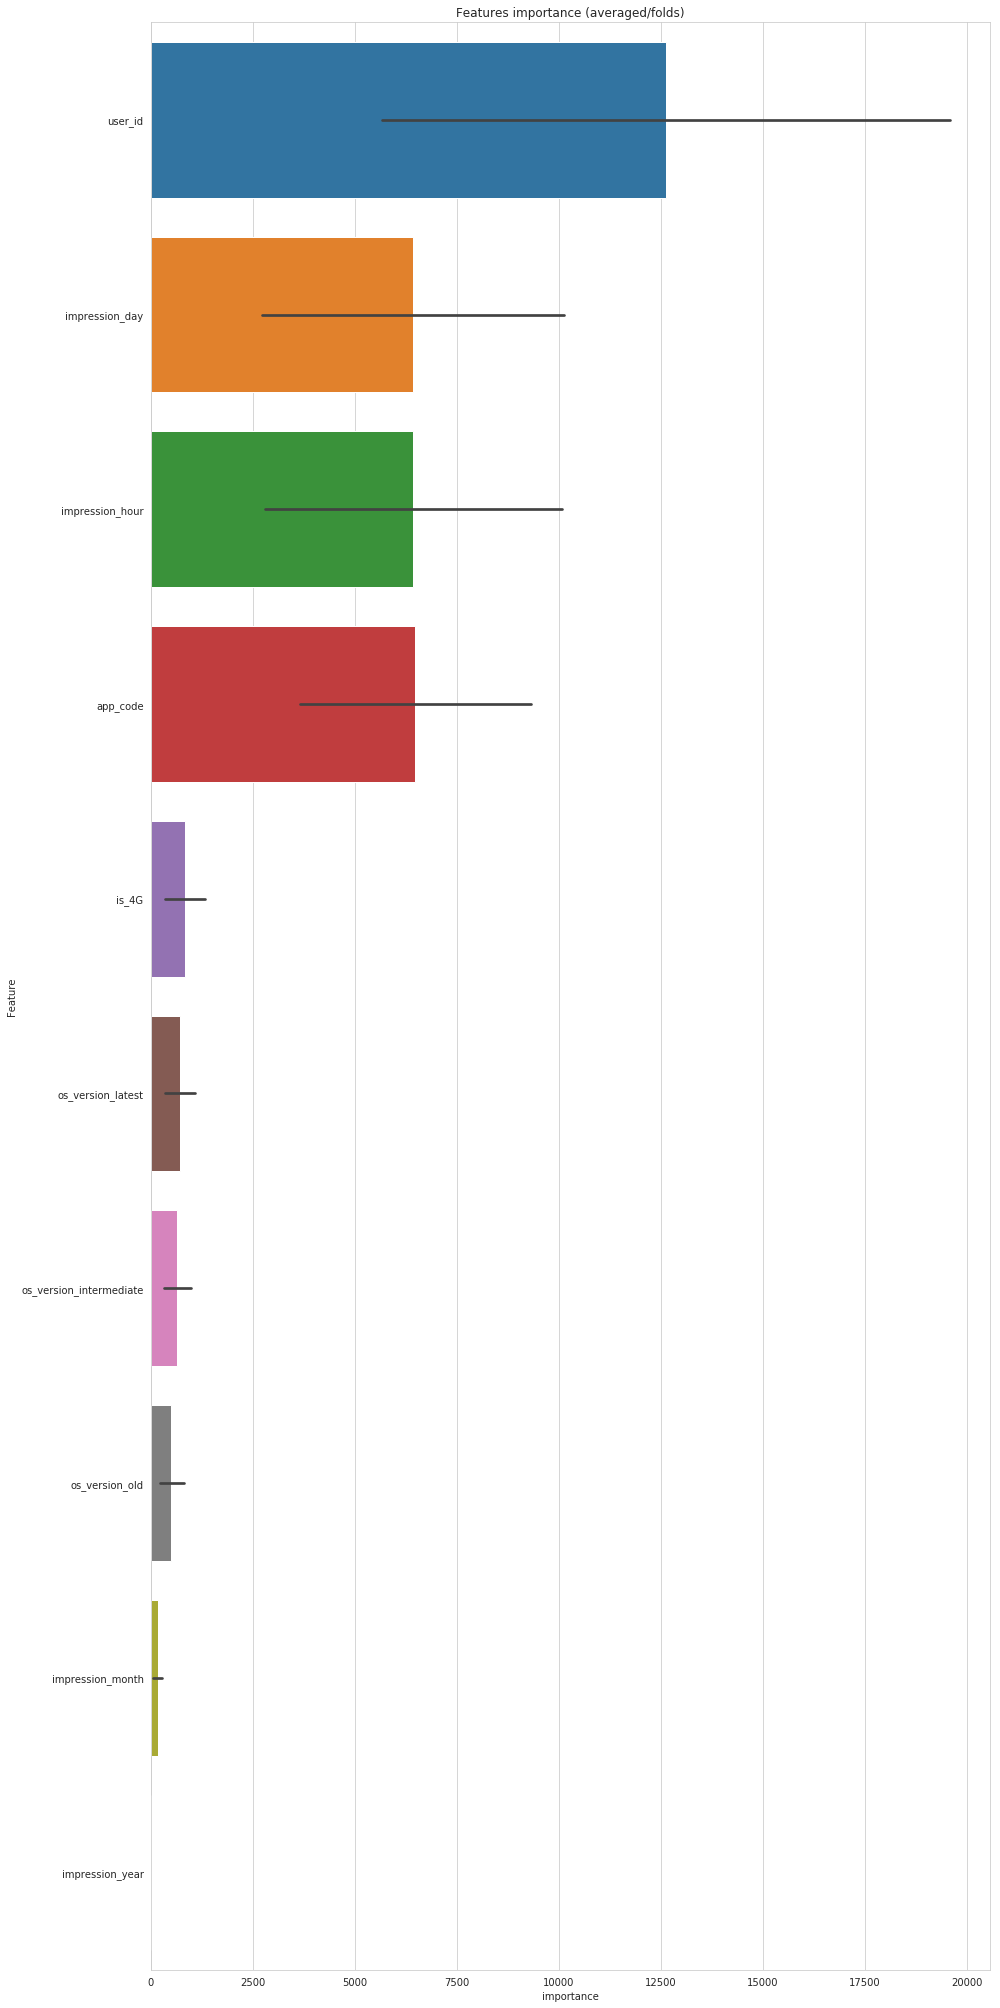

In [42]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')